In [ ]:
import json
import numpy as np
from scipy import stats
from tqdm import tqdm
from openai import OpenAI
import os
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
# Replace with your actual key
OPENAI_API_KEY = ""
client = OpenAI(api_key=OPENAI_API_KEY)

# Files
FILES = {
    "short_train": "short_complete.jsonl",
    "kidmode_train": "~kidmode_complete.jsonl", # Loaded but used only if needed; specific targets are hardcoded
    "composition_test": "composition_inference_results.jsonl", # Neo
    "baseline_test": "base_mistral_inference_results.jsonl"    # Baseline
}

def load_jsonl(filepath):
    data = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line))
        return data
    except FileNotFoundError:
        print(f"⚠️ Warning: Could not find {filepath}")
        return []

print("Environment setup complete.")

Environment setup complete.


In [2]:
# ============================================================================
# STATS HELPER (Generic)
# ============================================================================
def calculate_stats(values_list):
    """Generates the stats dictionary from a list of values."""
    values = np.array(values_list)
    if len(values) == 0:
        return {'mean': 0, 'median': 0, 'std': 0, 'count': 0, 'under_50_pct': 0, 'under_75_pct': 0, 'word_counts': []}
    
    return {
        'mean': np.mean(values),
        'median': np.median(values),
        'std': np.std(values),
        'count': len(values),
        'under_50_pct': (np.sum(values < 50) / len(values)) * 100,
        'under_75_pct': (np.sum(values < 75) / len(values)) * 100,
        'word_counts': values_list 
    }

# ============================================================================
# GAP CLOSURE FORMULA
# ============================================================================
def calculate_gap_closure(baseline_stats, training_stats, neo_stats):
    """Calculate gap closure percentage."""
    baseline_mean = baseline_stats['mean']
    training_mean = training_stats['mean']
    neo_mean = neo_stats['mean']
    
    # Calculate gaps
    gap_total = training_mean - baseline_mean
    gap_closed = neo_mean - baseline_mean
    gap_closure_pct = (gap_closed / gap_total) * 100 if gap_total != 0 else 0
    
    # Statistical significance (Baseline vs Neo)
    t_stat, p_value = stats.ttest_ind(
        baseline_stats['word_counts'], 
        neo_stats['word_counts']
    )
    
    return {
        'gap_total': gap_total,
        'gap_closed': gap_closed,
        'gap_closure_pct': gap_closure_pct,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# ============================================================================
# PRINT RESULTS
# ============================================================================
def print_results(baseline_stats, training_stats, neo_stats, gap_results, title="GAP CLOSURE RESULTS"):
    print("\n" + "="*70)
    print(f"📊 {title}")
    print("="*70)
    
    print("\n📋 SAMPLE SIZES")
    print("-" * 70)
    print(f"  Training Target:    {training_stats['count']}")
    print(f"  Test examples:      {baseline_stats['count']}")
    
    print("\n📏 METRIC STATISTICS")
    print("-" * 70)
    print(f"                       Mean      Median    Std Dev   % <50   % <75")
    print(f"  Baseline:            {baseline_stats['mean']:6.1f}    {baseline_stats['median']:6.1f}    {baseline_stats['std']:6.1f}   {baseline_stats['under_50_pct']:5.1f}  {baseline_stats['under_75_pct']:5.1f}")
    print(f"  Training Target:     {training_stats['mean']:6.1f}    {training_stats['median']:6.1f}    {training_stats['std']:6.1f}")
    print(f"  Composition:         {neo_stats['mean']:6.1f}    {neo_stats['median']:6.1f}    {neo_stats['std']:6.1f}   {neo_stats['under_50_pct']:5.1f}  {neo_stats['under_75_pct']:5.1f}")
    
    print("\n🎯 GAP CLOSURE ANALYSIS")
    print("-" * 70)
    print(f"  Total gap (Baseline -> Training):   {gap_results['gap_total']:7.2f}")
    print(f"  Gap closed (Baseline -> Neo):       {gap_results['gap_closed']:7.2f}")
    print(f"  ")
    print(f"  ⭐ GAP CLOSURE PERCENTAGE:         {gap_results['gap_closure_pct']:6.1f}%")
    
    print("\n📊 STATISTICAL SIGNIFICANCE")
    print("-" * 70)
    print(f"  t-statistic:          {gap_results['t_statistic']:8.4f}")
    print(f"  p-value:              {gap_results['p_value']:.4e}")
    print(f"  Significant (α=0.05): {'✅ Yes' if gap_results['significant'] else '❌ No'}")
    print("\n" + "="*70)

In [3]:
# 1. Training Data Loader (Uses 'chosen' column)
def load_training_data(filepath):
    """Load training data - use ALL examples."""
    print(f"Loading training data from {filepath}...")
    training_data = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                training_data.append(json.loads(line))
    except FileNotFoundError:
        print(f"⚠️ Warning: File not found: {filepath}")
        return {'mean': 0, 'count': 0, 'word_counts': []}
    
    # Calculate word counts on 'chosen'
    word_counts = [len(ex['chosen'].split()) for ex in training_data]
    
    print(f"✅ Loaded {len(training_data)} training examples")
    print(f"   Training mean: {np.mean(word_counts):.2f} words\n")
    
    # Return stats object directly
    return calculate_stats(word_counts)

# 2. Inference Data Loader (Uses 'response' column)
def load_inference_data(filepath):
    """Load inference data and extract raw responses."""
    data = []
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line))
        return data
    except FileNotFoundError:
        print(f"⚠️ Warning: File not found: {filepath}")
        return []

# Load the Inference Datasets into memory for use in all scores
baseline_data = load_inference_data(FILES["baseline_test"])
neo_data = load_inference_data(FILES["composition_test"])

# Truncate if lengths differ
if len(baseline_data) != len(neo_data):
    min_len = min(len(baseline_data), len(neo_data))
    baseline_data = baseline_data[:min_len]
    neo_data = neo_data[:min_len]
    print(f"⚠️ Truncated datasets to {min_len} examples to match lengths.")

In [4]:
print("--- Calculating SCORE 1: Shortness ---")

# 1. Get Target Stats (Training Data)
# Uses the specialized loader for 'chosen' column
stats_target_short = load_training_data(FILES["short_train"])

# 2. Get Inference Stats (Baseline & Neo)
# Helper to extract word counts from 'response'
def get_counts(dataset):
    return [len(ex['response'].split()) for ex in dataset]

stats_baseline_short = calculate_stats(get_counts(baseline_data))
stats_neo_short = calculate_stats(get_counts(neo_data))

# 3. Calculate Gap
gap_res_1 = calculate_gap_closure(stats_baseline_short, stats_target_short, stats_neo_short)

# 4. Print
print_results(stats_baseline_short, stats_target_short, stats_neo_short, gap_res_1, title="SCORE 1: ~SHORT ADHERENCE (WORD COUNT)")

--- Calculating SCORE 1: Shortness ---
Loading training data from short_complete.jsonl...


✅ Loaded 1030 training examples
   Training mean: 40.94 words


📊 SCORE 1: ~SHORT ADHERENCE (WORD COUNT)

📋 SAMPLE SIZES
----------------------------------------------------------------------
  Training Target:    1030
  Test examples:      300

📏 METRIC STATISTICS
----------------------------------------------------------------------
                       Mean      Median    Std Dev   % <50   % <75
  Baseline:             303.1     293.0     160.3     2.3    6.0
  Training Target:       40.9      42.0      10.1
  Composition:           81.7      62.0      58.1    24.7   65.3

🎯 GAP CLOSURE ANALYSIS
----------------------------------------------------------------------
  Total gap (Baseline -> Training):   -262.20
  Gap closed (Baseline -> Neo):       -221.44
  
  ⭐ GAP CLOSURE PERCENTAGE:           84.5%

📊 STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  t-statistic:           22.4581
  p-value:              1.8209e-81
  Significant (

In [5]:
print("--- Calculating SCORE 2: Kidmode ---")

TARGET_SCORE_KIDMODE = 7.5

# Judge Function
def get_kidmode_score(prompt, response):
    judge_prompt = f"""Rate how KID-FRIENDLY and APPROACHABLE this response is on a scale from 1-10. 

A score of 10 means: 
- An approachable, instructional tone and patient demeanor toward the user
- Extremely simple vocabulary and sentence structure with no technical jargon
- Explanations and analogies that assume no prior knowledge about the topic
- Shorter responses (<200-250 words)

A score of 1 means: 
- Reliance on long sentences with highly technical language / academic jargon
- Formal tone
- Communication of complex concepts
- Long responses (>400 words)

Examples:
Score 9-10: "Brain cells are like tiny workers in your head! They mostly stay in one place once they find their spot, kind of like how you have your own desk at school. When you're a baby, some brain cells do move around to find the perfect place to work, but once they're settled, they stay put."

Score 1-3: "The question of neuronal migration necessitates understanding the dynamic spatiotemporal regulation of cytoskeletal reorganization and chemoattractant gradients during cortical lamination..."

Instruction: {prompt}

Response: {response}

Provide ONLY a single number from 1-10, with no explanation:"""
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini", # or gpt-3.5-turbo
            messages=[{"role": "user", "content": judge_prompt}],
            temperature=0
        )
        return float(completion.choices[0].message.content.strip())
    except:
        return 0.0

# 1. Run Judge (Inference Data)
# Note: Training target is Hardcoded, so we skip loading training data for this score
print(f"Running Kidmode Judge on {len(baseline_data)} examples...")
baseline_k_scores = []
neo_k_scores = []

for b, n in tqdm(zip(baseline_data, neo_data), total=len(baseline_data)):
    baseline_k_scores.append(get_kidmode_score(b['prompt'], b['response']))
    neo_k_scores.append(get_kidmode_score(n['prompt'], n['response']))

stats_baseline_k = calculate_stats(baseline_k_scores)
stats_neo_k = calculate_stats(neo_k_scores)

# 2. Hardcoded Target Stats
# We assume 1030 examples as per your note for the count
stats_target_k = {
    'mean': TARGET_SCORE_KIDMODE, 'median': TARGET_SCORE_KIDMODE, 'std': 0.0, 
    'count': 1030, 'word_counts': [], 'under_50_pct': 0, 'under_75_pct': 0
}

# 3. Calculate Gap
gap_res_2 = calculate_gap_closure(stats_baseline_k, stats_target_k, stats_neo_k)
print_results(stats_baseline_k, stats_target_k, stats_neo_k, gap_res_2, title="SCORE 2: ~KIDMODE ADHERENCE (JUDGE)")

--- Calculating SCORE 2: Kidmode ---
Running Kidmode Judge on 300 examples...


100%|██████████| 300/300 [03:56<00:00,  1.27it/s]


📊 SCORE 2: ~KIDMODE ADHERENCE (JUDGE)

📋 SAMPLE SIZES
----------------------------------------------------------------------
  Training Target:    1030
  Test examples:      300

📏 METRIC STATISTICS
----------------------------------------------------------------------
                       Mean      Median    Std Dev   % <50   % <75
  Baseline:               3.0       3.0       1.6   100.0  100.0
  Training Target:        7.5       7.5       0.0
  Composition:            4.1       4.0       1.9   100.0  100.0

🎯 GAP CLOSURE ANALYSIS
----------------------------------------------------------------------
  Total gap (Baseline -> Training):      4.54
  Gap closed (Baseline -> Neo):          1.12
  
  ⭐ GAP CLOSURE PERCENTAGE:           24.8%

📊 STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  t-statistic:           -7.9468
  p-value:              9.5561e-15
  Significant (α=0.05): ✅ Yes



In [6]:
print("--- Calculating SCORE 3: Combined ---")

TARGET_SCORE_COMBINED = 10.0

def get_combined_score(prompt, response):
    judge_prompt = f"""
    Rate the following response on a scale of 1-10 based on TWO criteria:
    1. Is it SHORT? Answered the question concisely in under 50 words
    2. Is it KID-FRIENDLY?

    Meaning:
    - An approachable, instructional tone and patient demeanor toward the user
    - Extremely simple vocabulary and sentence structure with no technical jargon
    - Explanations and analogies that assume no prior knowledge about the topic
    - Shorter responses (<200-250 words)

    Not KID-FRIENDLY:
    - Reliance on long sentences with highly technical language / academic jargon
    - Formal tone
    - Communication of complex concepts
    - Long responses (>400 words)

    Examples:
    KID-FRIENDLY: "Brain cells are like tiny workers in your head! They mostly stay in one place once they find their spot, kind of like how you have your own desk at school. When you're a baby, some brain cells do move around to find the perfect place to work, but once they're settled, they stay put."

    NOT KID FRIENDLY: "The question of neuronal migration necessitates understanding the dynamic spatiotemporal regulation of cytoskeletal reorganization and chemoattractant gradients during cortical lamination..."

    A score of 10 on these two criteria requires excellence in BOTH categories. 
    Question: {prompt}
    Response: {response}
    Return ONLY a number.
    """
    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": judge_prompt}],
            temperature=0
        )
        return float(completion.choices[0].message.content.strip())
    except:
        return 0.0

print(f"Running Combined Judge on {len(baseline_data)} examples...")
baseline_c_scores = []
neo_c_scores = []

for b, n in tqdm(zip(baseline_data, neo_data), total=len(baseline_data)):
    baseline_c_scores.append(get_combined_score(b['prompt'], b['response']))
    neo_c_scores.append(get_combined_score(n['prompt'], n['response']))

stats_baseline_c = calculate_stats(baseline_c_scores)
stats_neo_c = calculate_stats(neo_c_scores)

# Hardcoded Target
stats_target_c = {
    'mean': TARGET_SCORE_COMBINED, 'median': TARGET_SCORE_COMBINED, 'std': 0.0, 
    'count': "Ideal", 'word_counts': [], 'under_50_pct': 0, 'under_75_pct': 0
}

gap_res_3 = calculate_gap_closure(stats_baseline_c, stats_target_c, stats_neo_c)
print_results(stats_baseline_c, stats_target_c, stats_neo_c, gap_res_3, title="SCORE 3: COMBINED ADHERENCE")

--- Calculating SCORE 3: Combined ---
Running Combined Judge on 300 examples...


100%|██████████| 300/300 [04:17<00:00,  1.16it/s]


📊 SCORE 3: COMBINED ADHERENCE

📋 SAMPLE SIZES
----------------------------------------------------------------------
  Training Target:    Ideal
  Test examples:      300

📏 METRIC STATISTICS
----------------------------------------------------------------------
                       Mean      Median    Std Dev   % <50   % <75
  Baseline:               2.7       3.0       1.3   100.0  100.0
  Training Target:       10.0      10.0       0.0
  Composition:            3.8       4.0       1.5   100.0  100.0

🎯 GAP CLOSURE ANALYSIS
----------------------------------------------------------------------
  Total gap (Baseline -> Training):      7.32
  Gap closed (Baseline -> Neo):          1.11
  
  ⭐ GAP CLOSURE PERCENTAGE:           15.2%

📊 STATISTICAL SIGNIFICANCE
----------------------------------------------------------------------
  t-statistic:           -9.6697
  p-value:              1.1982e-20
  Significant (α=0.05): ✅ Yes



✅ Results saved to composition_gap_results.json
✅ Chart saved to gap_closure_chart_with_std.png


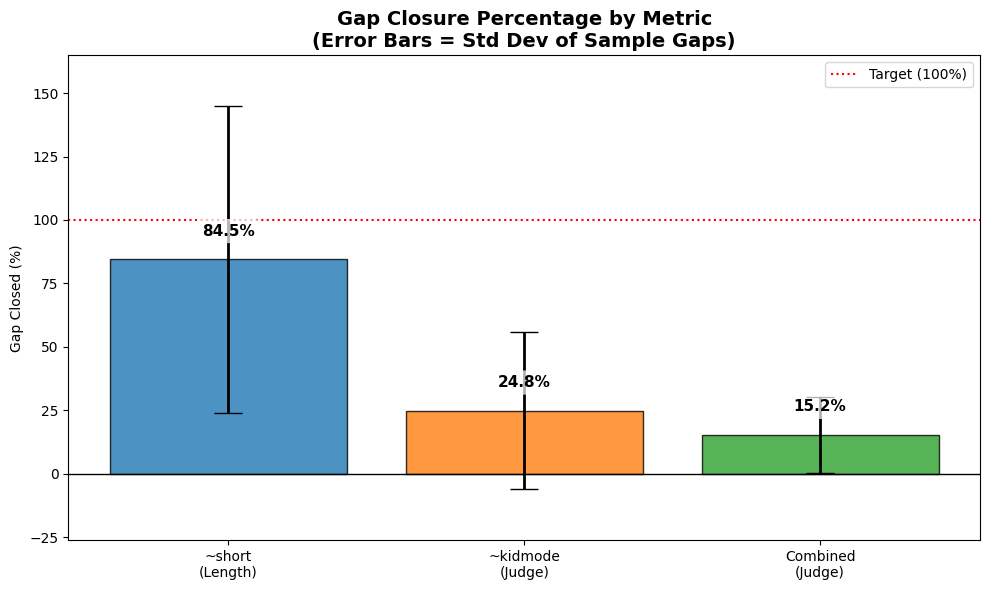

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# 1. HELPER: Calculate Standard Deviation of the Gap Closure
# ============================================================================
def get_gap_closure_std(baseline_stats, neo_stats, target_stats):
    """
    Calculates the Standard Deviation of the Gap Closure % across individual examples.
    Formula per sample: 100 * (Neo_i - Baseline_i) / (Target_Mean - Baseline_Mean)
    """
    b_vals = np.array(baseline_stats['word_counts'])
    n_vals = np.array(neo_stats['word_counts'])
    
    # Ensure lengths match (truncate to minimum if necessary)
    min_len = min(len(b_vals), len(n_vals))
    b_vals = b_vals[:min_len]
    n_vals = n_vals[:min_len]
    
    # Denominator: The total gap distance (mean to mean)
    gap_total = target_stats['mean'] - baseline_stats['mean']
    
    if gap_total == 0:
        return 0.0
    
    # Calculate gap closure % for EACH sample
    # (How much of the total required distance did this specific example cover?)
    sample_gaps = 100 * (n_vals - b_vals) / gap_total
    
    return np.std(sample_gaps)

# ============================================================================
# 2. CALCULATE ERRORS (WHISKERS)
# ============================================================================
# Note: These variables (stats_baseline_short, etc.) must exist from previous cells
std_1 = get_gap_closure_std(stats_baseline_short, stats_neo_short, stats_target_short)
std_2 = get_gap_closure_std(stats_baseline_k, stats_neo_k, stats_target_k)
std_3 = get_gap_closure_std(stats_baseline_c, stats_neo_c, stats_target_c)

error_bars = [std_1, std_2, std_3]

# ============================================================================
# 3. ROBUST SAVE (Clean Data)
# ============================================================================
def clean_stats_dict(stats_dict):
    """Creates a fresh dict with only serializable values to avoid circular refs."""
    clean = {}
    for k, v in stats_dict.items():
        if isinstance(v, (np.integer, int)): clean[k] = int(v)
        elif isinstance(v, (np.floating, float)): clean[k] = float(v)
        elif isinstance(v, np.ndarray): clean[k] = v.tolist()
        elif isinstance(v, (bool, np.bool_)): clean[k] = bool(v)
        else: clean[k] = v
    return clean

final_results = {
    "Score 1 (~short)": {
        "gap_pct": float(gap_res_1['gap_closure_pct']), 
        "std_dev": float(std_1),
        "stats": clean_stats_dict(gap_res_1)
    },
    "Score 2 (~kidmode)": {
        "gap_pct": float(gap_res_2['gap_closure_pct']), 
        "std_dev": float(std_2),
        "stats": clean_stats_dict(gap_res_2)
    },
    "Score 3 (Combined)": {
        "gap_pct": float(gap_res_3['gap_closure_pct']), 
        "std_dev": float(std_3),
        "stats": clean_stats_dict(gap_res_3)
    }
}

with open("composition_gap_results.json", 'w', encoding='utf-8') as f:
    json.dump(final_results, f, indent=4)
print("✅ Results saved to composition_gap_results.json")

# ============================================================================
# 4. PLOT CHART WITH WHISKERS
# ============================================================================
plt.figure(figsize=(10, 6))

labels = ["~short\n(Length)", "~kidmode\n(Judge)", "Combined\n(Judge)"]
values = [final_results[k]["gap_pct"] for k in final_results]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot Bars with Error Bars (capsize adds the horizontal line at the end of the whisker)
bars = plt.bar(labels, values, yerr=error_bars, capsize=10, 
               color=colors, edgecolor='black', alpha=0.8, error_kw={'elinewidth': 2})

# Reference Lines
plt.axhline(0, color='black', linewidth=1)
plt.axhline(100, color='red', linestyle=':', label='Target (100%)')

# Styling
plt.title('Gap Closure Percentage by Metric\n(Error Bars = Std Dev of Sample Gaps)', fontsize=14, fontweight='bold')
plt.ylabel('Gap Closed (%)')
plt.legend()

# Dynamic Y-Limit to fit whiskers
max_val = max([v + e for v, e in zip(values, error_bars)])
min_val = min([v - e for v, e in zip(values, error_bars)])
plt.ylim(min(0, min_val) - 20, max(110, max_val) + 20)

# Add Labels
for bar in bars:
    height = bar.get_height()
    # Adjust label position based on whether bar is positive or negative
    xy_pos = (bar.get_x() + bar.get_width()/2., height)
    xy_text = (0, 15 if height >= 0 else -25) # Push label further out to avoid whiskers
    
    plt.annotate(f'{height:.1f}%', 
                 xy=xy_pos, 
                 xytext=xy_text,
                 textcoords='offset points',
                 ha='center', va='bottom', fontweight='bold', fontsize=11,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, ec="none"))

plt.tight_layout()
plt.savefig('gap_closure_chart_with_std.png', dpi=300)
print("✅ Chart saved to gap_closure_chart_with_std.png")
plt.show()